## Méthodes d'optimisation stochastique

## I. Minimisation stochastique d'une fonction déterministe


On s'intéresse au problème $\min f(x) =\max_{i=1\dots m}|a_i^Tx-b_i | = \max_{i=1\dots m} |(Ax-b)_i|.$ 

On suppose que $a_i$ est un vecteur colonne représentant la $i$eme ligne d'une matrice $A$ de taille $m \times n$ ($m=100, n=20$) , et les $b_i$ sont les composantes d'un second membre $b$ de taille $m$, ($1 \le i \le m$), $x$ un vecteur de taille $n$. Ces quantités sont générées une fois pour toutes à partir de distributions Gaussiennes de moyenne nulle et d'écart type identité.

**Question 1 :** Constuire $A$ et $b$. Proposer le calcul d'un sous-gradient en $x$ de $f$. On pourra utiliser la fonction findmax de Julia. 


**Réponse 1:** On a $f(x)=max_{i=1\dots m}\lvert a_i^Tx-bi \lvert = max_{i=1\dots m} g_i(x)$ avec $g_i(x) = \lvert a_i^Tx-b_i \lvert$

Donc on a: $$\partial f(x) = conv \bigcup_{i \in I} \partial g_i(x)  $$  
$$\partial f(x) = conv \bigcup_{i \in I} \left\{ signe(f(x))a_i \right\} $$ 
où $I = \left\{ i : f(x) = g_i(x)\right\}$ 

Au final on a:
$$\partial f(x) = signe(f(x))a_{i_0} ~ où ~ i_0 = argmax_{i = 1 \dots m } \lvert a_i^Tx-bi \lvert$$




In [421]:
# Construction des données A  et b
n = 20;
m = 100;

A = randn(m,n)
b = randn(m,1)
x = zeros(n,1)

# Fonction calculant la valeur de f en x 
function fval(A,b,x)
    return maximum(abs.(A*x - b))
end

# Fonction calculant un sous-gradient en x de f
function subgrad(A,b,x) 
    fx = A*x - b
    (~,ind) = findmax(abs.(fx))
    i = ind[1]
    return sign(fx[i]) .* (A[i,:])
end

     

subgrad (generic function with 1 method)

**Question 2 :** Ce problème peut se reformuler comme un problème de programmation linéaire : $$(\mathcal{P}_{lp})\quad \left\{ \begin{array}{c} \min_{(x,R)\in \mathbb{R}^n\times \mathbb{R}} h(x,R)=R\\
s.c. \quad-R*e\leq A*x-b\leq R*e\end{array}\right.$$ avec $e=[1,\cdots,1]^T\in \mathbb{R}^m$. Résoudre le problème $(\mathcal{P}_{lp})$ en utilisant le solveur "GLPK" de la librairie JuMP. Plus d'informations sont disponibles ici :  http://www.juliaopt.org/JuMP.jl/latest/quickstart/

In [422]:
#using Pkg
#Pkg.add("JuMP"); 
#Pkg.add("GLPK")
using JuMP
using GLPK

# Définition du modèle
# Insérer votre code
model = Model(GLPK.Optimizer);
# Fin insérer code

# Définition des variables d'optimisation
# Insérer votre code
@variable(model, x[1:n]);
@variable(model, R);
# Fin insérer code

# Définition de la fonctionnelle à minimiser
#Insérer votre code
@objective(model, Min, R);
# Fin insérer code

# Définition des contraintes
# Insérer votre code
@constraint(model, c1[i=1:m], -R <= sum(A[i,j]*x[j] for j in 1:n) - b[i]);
@constraint(model, c2[i=1:m], R >= sum(A[i,j]*x[j] for j in 1:n) - b[i]);
# Fin insérer code
        
# Résolution        
# Insérer votre code
optimize!(model);
# Fin insérer code
        
# Résultats à optimalité                
# Insérer votre code

println(solution_summary(model))
xstar = value.(x)
Rstar = value(R)

# Fin insérer code
println("The function value at the solution is: ",Rstar, " or ",findmax(abs.(A*xstar-b)))


* Solver : GLPK

* Status
  Termination status : OPTIMAL
  Primal status      : FEASIBLE_POINT
  Dual status        : FEASIBLE_POINT
  Message from the solver:
  "Solution is optimal"

* Candidate solution
  Objective value      : 1.59823e+00
  Objective bound      : -Inf
  Dual objective value : 1.59823e+00

* Work counters
  Solve time (sec)   : 1.70708e-03

The function value at the solution is: 1.5982276249291842 or (1.5982276249291858, CartesianIndex(79, 1))


**Question 3 :** Résoudre le problème en utilisant un algorithme de sous-gradient. Dans un premier temps vous utiliserez un sous-gradient exact (Question 1), puis vous introduirez un bruit artificiel qui suit une distribution normale de moyenne nulle et d'écart-type $3 e-1$.

**Question 4 :** Vous afficherez les courbes de convergence de $f_{best}^k-f_{star}$, avec $f_{star}$ obtenue à la Question 1. Donnez la valeur minimale de $f_{best}^k-f_{star}$.

The final value of the difference of the exact subgradient is: 0.004893212120589352
The final value of the difference of the noisy subgradient is: 0.011479955915461248


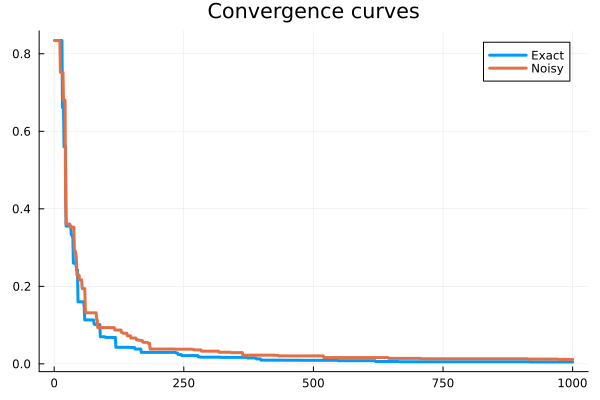

In [423]:
#Pkg.add("Plots")
using Plots

#Initialisation
x = zeros(n,1);
i = 0;
fbest =1e10; # $f_{best}^0$: cas du sous-gradient exact
fbestp=1e10; # $f_{best}^0$: cas du sous-gradient bruité
histo =[];# Suite des itérés f_{best}^k-f_{star} pour le cas du sous-gradient exact
histop=[];# Suite des itérés f_{best}^k-f_{star}, pour le cas du sous-gradient bruité

#Niveau de bruit
noise_lvl=.3;

# Resolution 
# Insérer votre code
# Resolution 
# Initialisation des variables 
itermax = 1000;
xk = x;
xpk = x;
# Rstar est le résultat obtenu par le solveur GLPK 
f_star = Rstar;

for i in 1:itermax
    alpha = 1/i;

    # Calcul de l'itération avec le gradient exact 
    
    fbest = min(fbest, fval(A,b,xk));
    g = subgrad(A,b,xk);
    xk = xk - alpha*g;
    # Stockage
    append!(histo, fbest-f_star)
    
    # Calcul de l'itération avec le gradient bruité 
    
    fbestp = min(fbestp, fval(A,b,xpk));
    
    # Calcule un sous-gradient et y ajoute un bruit 
    # de niveau de bruit donné noise_lvl
    gp = subgrad(A,b,xpk) + noise_lvl*randn(n,1);
    xpk = xpk - alpha*gp;
    # Stockage
    append!(histop, fbestp-f_star)
    
end

# Fin insérer code

#Afficher les valeurs finales de histop et histo
println("The final value of the difference of the exact subgradient is: ",histo[end])
println("The final value of the difference of the noisy subgradient is: ",histop[end])


#Affichage des courbes de convergence
iter=1:itermax;
hf=[histo,histop];
plot(iter,hf,title="Convergence curves",label=["Exact" "Noisy"],lw=3)


## II. Minimisation stochastique d'une fonction stochatique



On s'intéresse au problème
$$\min_x f(x) =\text{E} (\max_{i=1\dots m}|a_i^Tx-b_i |).$$

On suppose que $a_i$ est un vecteur colonne représentant la $i$eme ligne d'une matrice $A$ de taille $m \times n$ ($m=100, n=20$) , et les $b_i$ sont les composantes d'un second membre $b$ de taille $m$, ($1 \le i \le m$), $x$ un vecteur de taille $n$. Ces quantités sont générées une fois pour toutes à partir de distributions Gaussiennes de moyenne connue $\bar{A}$ et $\bar{b}$ (non nécesairement nulle) et d'écart type identité.

**Question 5 :** Proposer deux fonctions d'évaluation de la fonction $f$ et d'un sous-gradient de $f$ basées sur des échantillons de taille $M$.


In [435]:
# Evaluation de f
function fvals(Abar,bbar,noise,xs,M) 
    # Abar, bbar : moyenne des données
    # noise : niveau de bruit 
    # xs : vecteur courant 
    # M: taille de l'échantillon

    # Insérer votre code
    sum = 0;
    #ajouter le bruit
    for i in 1:M
        sum += fval(Abar + noise*randn(m,n), bbar + noise*randn(m,1), xs);
    end
    return sum/M
    # Fin insérer code

end

# Evaluation d'un sous-gradient
function subgrads(Abar,bbar,noise,xs,M)
    # Abar, bbar : moyenne des données
    # noise : niveau de bruit 
    # xs : vecteur courant 
    # M: taille de l'échantillon
    
# Insérer votre code
    sum = zeros(n,1);
    #ajouter le bruit
    for i in 1:M
        sum += subgrad(Abar + noise*randn(m,n), bbar + noise*randn(m,1), xs);
    end
    return sum/M
# Fin insérer code

end


subgrads (generic function with 1 method)

**Question 6 :** Comparer les courbes de convergence du problème déterministe $$ \min_x f(x) = \max_{i=1\dots m}|\text{E} (a_i)^Tx-\text{E} (b_i) |,$$ et du problème stochastique obtenu avec $M=10,100,1000$ échantillons. Donnez la valeur minimale de $f$.

The final value of the difference of the deterministic subgradient is: 59.50839486364749
The final value of the difference of the stochastic subgradient is: 31.638996136848938


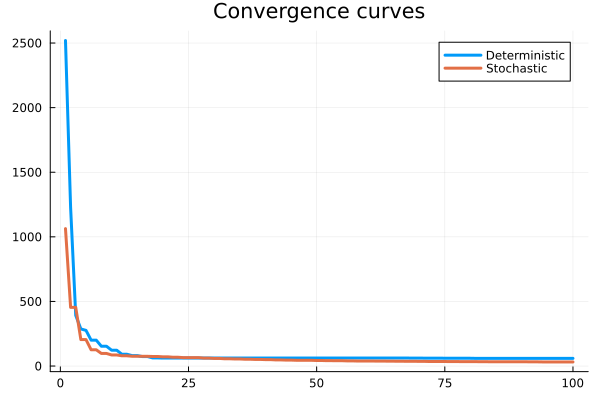

In [450]:
# Données
Abar=10*ones(m,n)+1*randn(m,n);
bbar=10*randn(m,1);



#x_0
xd = zeros(n,1); # problème déterministe
xs = xd; # problème stochastique

# Bruit et echantillon
M  = 200;
noise  = 4;

j = 0;

fbestd =1e10; # $f_{best}^0$: cas d'une résolution déterministe
fbests =1e10; # $f_{best}^0$: cas d'une résolution stochastique
histod =[]; # Suite des itérés f_{best}^k pour le cas d'une résolution déterministe
histos =[]; # Suite des itérés f_{best}^k pour le cas d'une résolution stochastique

# Insérer votre code
# Initialisation des variables
itermax = 100;


for i in 1:itermax

    # Calcule un sous-gradient et y ajoute un bruit
    gs = subgrads(Abar,bbar,noise,xs,M);
    gd = subgrad(Abar,bbar,xd);

    # Mise-à-jour des variables
    alpha = 1/(i);
    xs = xs - alpha*gs;
    xd = xd - alpha*gd;

    # Calcul de l'itération avec le gradient exact
    fbests = min(fbests, fvals(Abar,bbar,noise,xs,M));

    # Calcul de l'itération avec le gradient bruité
    fbestd = min(fbestd, fvals(Abar,bbar,noise,xd,M));

    # Stockage
    append!(histod, fbestd)
    append!(histos, fbests)
    
end
# Fin insérer code
#Affichage

#Afficher les valeurs finales de histod et histos
println("The final value of the difference of the deterministic subgradient is: ",histod[end])
println("The final value of the difference of the stochastic subgradient is: ",histos[end])

iter=1:itermax;
hf=[histod,histos];
plot(iter,hf,title="Convergence curves",label=["Deterministic" "Stochastic"],lw=3)

**Question 7 :** Répéter les expériences et comparer les valeurs meilleurs valeurs de f obtenues ($f_{best}$) aprs un nombre fixé d'itérations. Donnez la valeur minimale de $f_{best}$

The minimum value of the deterministic subgradient is: 54.15913669142927
The minimum value of the stochastic subgradient is: 32.89746707269508


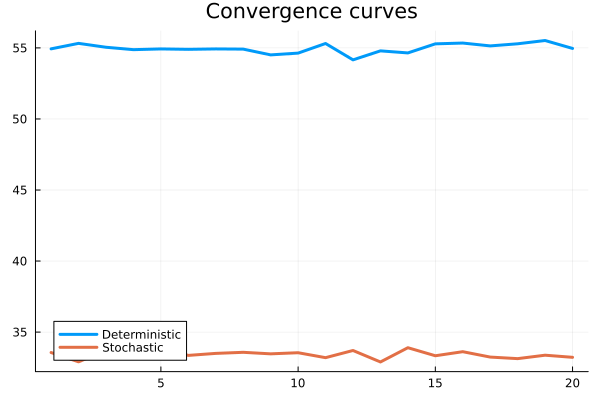

In [452]:
# Données
Abar=10*ones(m,n)+1*randn(m,n);
bbar=10*randn(m,1);

# x_0
xd = zeros(n,1); # résolution déterministe
xs = xd;  # résolution stochastique

# Bruit et echantillon
M  = 200;
noise  = 4;

#Nombre d'itérations
niter=100;

j = 0;

fbestd =1e10; # $f_{best}^0$: cas d'une résolution déterministe
fbests =1e10; # $f_{best}^0$: cas d'une résolution stochastique
fbesttd=[]; # f_{best} pour chaque expériences dans le cas d'une résolution déterministe
fbestts=[]; # f_{best} pour chaque expériences dans le cas d'une résolution stochastique

for nexp=1:20
    # Répétition des expériences    
    # Insérer votre code
    # Initialisation des variables
    fbestd =1e10; # $f_{best}^0$: cas d'une résolution déterministe
    fbests =1e10; # $f_{best}^0$: cas d'une résolution stochastique
    xd = zeros(n,1); # résolution déterministe
    xs = xd;  # résolution stochastique
    for i in 1:niter
        
        # Calcule un sous-gradient et y ajoute un bruit
        gs = subgrads(Abar,bbar,noise,xs,M);
        gd = subgrad(Abar,bbar,xd);

        # Mise-à-jour des variables
        alpha = 1/(i);
        xs = xs - alpha*gs;
        xd = xd - alpha*gd;

        # Calcul de l'itération avec le gradient exact
        fbests = min(fbests, fvals(Abar,bbar,noise,xs,M));

        # Calcul de l'itération avec le gradient bruité
        fbestd = min(fbestd, fvals(Abar,bbar,noise,xd,M));

    end

    # Stockage
    append!(fbesttd, fbestd)
    append!(fbestts, fbests)

    # Fin insérer code
end

#Affichage

#Valeur minimal de fbest

println("The minimum value of the deterministic subgradient is: ",minimum(fbesttd))
println("The minimum value of the stochastic subgradient is: ",minimum(fbestts))

iter=1:20;
hf=[fbesttd,fbestts];
plot(iter,hf,title="Convergence curves",label=["Deterministic" "Stochastic"],lw=3)